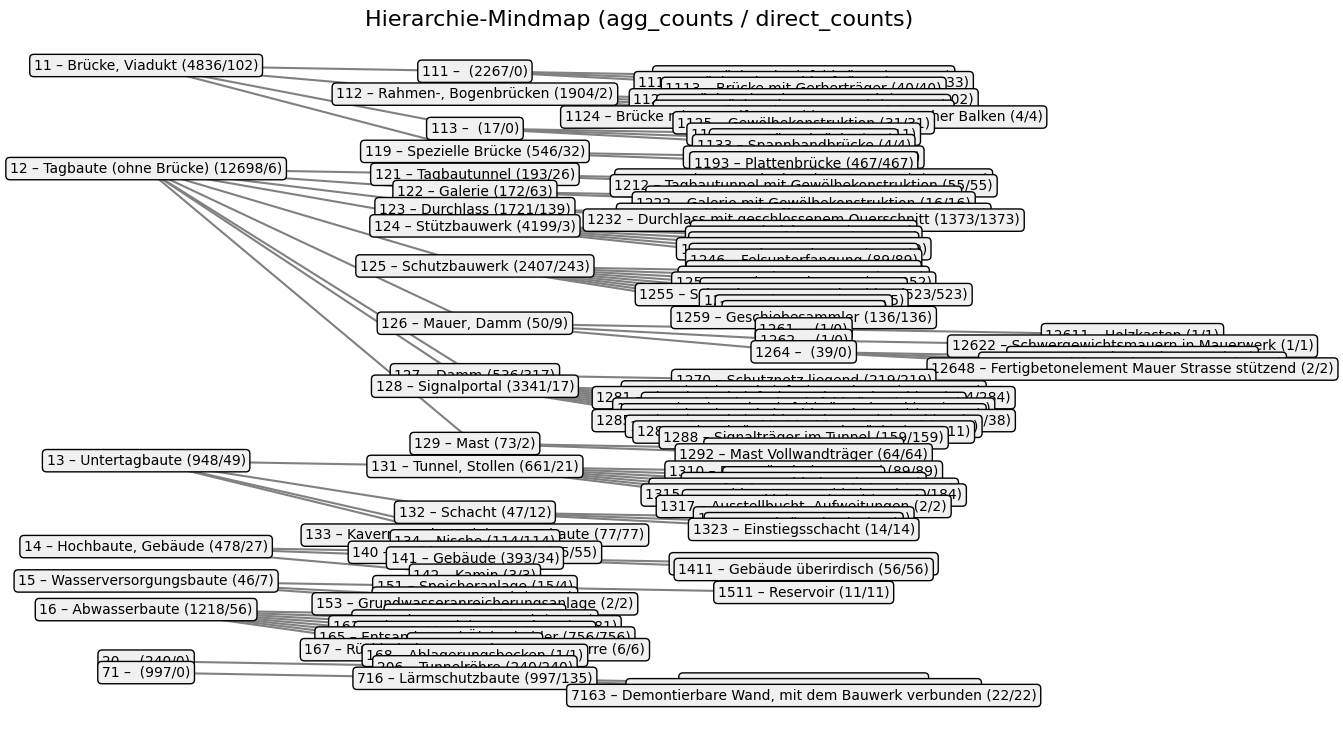

=== Textuelle Baumstruktur (agg_counts / direct_counts) ===

- 11 – Brücke, Viadukt (4836/102)
  - 111 –  (2267/0)
    - 1111 – Brücke mit Einfeldträger (494/494)
    - 1112 – Brücke mit Durchlaufträger (1733/1733)
    - 1113 – Brücke mit Gerberträger (40/40)
  - 112 – Rahmen-, Bogenbrücken (1904/2)
    - 1121 – Brücke mit Rahmentragwerk (1502/1502)
    - 1122 – Brücke mit Sprengwerk (304/304)
    - 1123 – Brücke mit Bogentragwerk (61/61)
    - 1124 – Brücke mit versteiftem Stabbogen / Langerscher Balken (4/4)
    - 1125 – Gewölbekonstruktion (31/31)
  - 113 –  (17/0)
    - 1131 – Schrägseilbrücke (11/11)
    - 1132 – Hängebrücke (2/2)
    - 1133 – Spannbandbrücke (4/4)
  - 119 – Spezielle Brücke (546/32)
    - 1192 – Brücke auf Wanne (47/47)
    - 1193 – Plattenbrücke (467/467)
- 12 – Tagbaute (ohne Brücke) (12698/6)
  - 121 – Tagbautunnel (193/26)
    - 1211 – Tagbautunnel mit Rahmentragwerk (112/112)
    - 1212 – Tagbautunnel mit Gewölbekonstruktion (55/55)
  - 122 – Galerie (172/63

In [13]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# --- CSV einlesen ---
df = pd.read_csv("20250318_Export_KUBA_EPZ-KernInfO_DE_FR.csv", sep=";", engine="python")
df.columns = df.columns.str.strip()

HIER_CODE_COL = 4   # 5. Spalte: Hierarchiecode
TYPE_NAME_COL = 5   # 6. Spalte: Typ-Name

# --- Mapping Code -> Typ-Name ---
code_to_name = {}
for _, row in df.iterrows():
    code = str(row.iloc[HIER_CODE_COL]).strip()
    name = str(row.iloc[TYPE_NAME_COL]).strip()
    if code and code not in code_to_name:
        code_to_name[code] = name

# --- Counts berechnen ---
agg_counts = defaultdict(int)    # Hochaggregiert
direct_counts = defaultdict(int) # Nur in eigener Ebene

for code in df.iloc[:, HIER_CODE_COL].dropna():
    code = str(code).strip()
    direct_counts[code] += 1
    for level in range(2, len(code)+1):
        prefix = code[:level]
        agg_counts[prefix] += 1

# --- Baumstruktur ---
tree = defaultdict(list)
for code in agg_counts:
    if len(code) > 2:
        parent = code[:-1]
        if parent in agg_counts:
            tree[parent].append(code)

# --- Label Funktion ---
def label(code):
    name = code_to_name.get(code, "")
    agg = agg_counts[code]
    direct = direct_counts.get(code, 0)
    return f"{code} – {name} ({agg}/{direct})"

# --- Positionen berechnen (Baum links->rechts) ---
positions = {}
y = 0
def assign_positions(code, level=0):
    global y
    positions[code] = (level, y)
    y -= 1
    for child in sorted(tree.get(code, [])):
        assign_positions(child, level + 1)

roots = sorted([c for c in agg_counts if len(c) == 2])
for r in roots:
    assign_positions(r)

# --- Grafische Mindmap ---
fig, ax = plt.subplots(figsize=(14, 9))

for code, (x, y) in positions.items():
    ax.text(
        x, y,
        label(code),
        ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="#f0f0f0", edgecolor="black")
    )
    if len(code) > 2:
        parent = code[:-1]
        if parent in positions:
            x2, y2 = positions[parent]
            ax.plot([x2, x], [y2, y], color="gray")

ax.axis("off")
plt.title("Hierarchie-Mindmap (agg_counts / direct_counts)", fontsize=16)
plt.show()

# --- Textuelle Baumstruktur (agg_counts / direct_counts) ---
def print_tree(code, level=0):
    """
    Rekursive Ausgabe der Hierarchie als Textbaum.
    - code: Hierarchiecode
    - level: Ebene (für Einrückung)
    """
    indent = "  " * level
    name = code_to_name.get(code, "")
    agg = agg_counts[code]
    direct = direct_counts.get(code, 0)
    print(f"{indent}- {code} – {name} ({agg}/{direct})")
    
    for child in sorted(tree.get(code, [])):
        print_tree(child, level + 1)

# Wurzelebenen (2-stellige Codes)
roots = sorted([c for c in agg_counts if len(c) == 2])

print("=== Textuelle Baumstruktur (agg_counts / direct_counts) ===\n")
for r in roots:
    print_tree(r)


###

from collections import defaultdict
def direct_objects_button(code, code_to_objects):
    objs = code_to_objects.get(code, [])
    
    if not objs:
        return None
    
    btn = widgets.Button(
        description=f"📄 Direkte Einträge ({len(objs)})",
        layout=widgets.Layout(width="auto")
    )
    
    def on_click(b, code_val=code):
        display(Markdown(
            f"### Direkte Objekte für {code_val} – {code_to_name.get(code_val,'')}\n"
            + "\n".join(f"- {o}" for o in objs)
        ))
    
    btn.on_click(on_click)
    return btn

# Annahme:
# Spalte 2 (Index 1) + Spalte 3 (Index 2) = Objektbezeichnung
OBJ1_COL = 1
OBJ2_COL = 2

code_to_objects = defaultdict(list)

for _, row in df.iterrows():
    code = str(row.iloc[HIER_CODE_COL]).strip()
    obj_name = f"{row.iloc[OBJ1_COL]} / {row.iloc[OBJ2_COL]}"
    
    if code:
        code_to_objects[code].append(obj_name)

print("code_to_objects erzeugt für", len(code_to_objects), "Codes")

###
import ipywidgets as widgets
from IPython.display import display, Markdown

# Funktion zur Rekursion durch Baum
import ipywidgets as widgets
from IPython.display import display, Markdown

def create_tree_widget(code, code_to_objects):
    agg = agg_counts[code]
    direct = direct_counts.get(code, 0)
    name = code_to_name.get(code, "")
    
    header = widgets.HTML(
        value=f"<b>{code}</b> – {name} "
              f"<span style='color:gray'>({agg} / {direct})</span>"
    )
    
    elements = [header]
    
    # 📄 Direkte Einträge-Button (auch bei Eltern!)
    direct_btn = direct_objects_button(code, code_to_objects)
    if direct_btn:
        elements.append(direct_btn)
    
    # 🌳 Kinder
    children = sorted(tree.get(code, []))
    if children:
        child_widgets = [
            create_tree_widget(child, code_to_objects)
            for child in children
        ]
        acc = widgets.Accordion(children=child_widgets)
        for i, c in enumerate(children):
            acc.set_title(i, c)
        elements.append(acc)
    
    return widgets.VBox(elements)   

# Wurzelebenen
roots = sorted([c for c in agg_counts if len(c) == 2])

widgets_list = [
    create_tree_widget(r, code_to_objects)
    for r in roots
]

display(*widgets_list)
